# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
## Importing Dataset

In [2]:
data_train = pd.read_csv("fashion-mnist_train.csv")
data_test = pd.read_csv("fashion-mnist_test.csv")

## Standardizing and Train-Val-Test Split

In [3]:
X_full = data_train.drop('label', axis=1)
y_full = data_train['label']
X_test = data_test.drop('label', axis=1)
y_test = data_test['label']
mean = X_full.mean()
std = X_full.std()
X_full = (X_full-mean)/std
X_test = (X_test-mean)/std
np.random.seed(42)
n_samples = len(X_full)
n_val = int(n_samples * 0.1)

indices = np.random.permutation(n_samples)
val_indices = indices[:n_val]
train_indices = indices[n_val:]

# Split the data
X_train = X_full.iloc[train_indices]
X_val = X_full.iloc[val_indices]
y_train = y_full.iloc[train_indices]
y_val = y_full.iloc[val_indices]
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values
y_train_onehot = pd.get_dummies(y_train).values
y_val_onehot = pd.get_dummies(y_val).values
y_test_onehot = pd.get_dummies(y_test).values

# Creation of Neural Network
## Implementation of single layer

In [4]:
class Layer:
    def __init__(self, n_inputs, n_neurons, activation='relu', optimizer = 'gd'):
        self.weights = np.random.normal(0, np.sqrt(2.0/n_inputs), size=(n_inputs, n_neurons)) # He Initializaion
        self.biases = np.zeros((1, n_neurons))
        self.activation = activation
        self.optimizer = optimizer
        # NAG parameters
        self.v_weights = np.zeros_like(self.weights)
        self.v_biases = np.zeros_like(self.biases)
        self.momentum = 0.9  # typical momentum value
        # Adam parameters
        self.m_weights = np.zeros_like(self.weights)
        self.v_weights_adam = np.zeros_like(self.weights)
        self.m_biases = np.zeros_like(self.biases)
        self.v_biases_adam = np.zeros_like(self.biases)
        self.beta1 = 0.9  # exponential decay rate for first moment
        self.beta2 = 0.999  # exponential decay rate for second moment
        self.epsilon = 1e-8  # small constant for numerical stability
        self.t = 0  # time step
    def forward(self, inputs):
        self.inputs = inputs
        if self.optimizer == 'nag':
            weights_ahead = self.weights + self.momentum * self.v_weights
            biases_ahead = self.biases + self.momentum * self.v_biases
            self.z = np.dot(inputs, weights_ahead) + biases_ahead
        else:
            self.z = np.dot(inputs, self.weights) + self.biases
        if self.activation == 'relu':
            self.output = np.maximum(0, self.z)
        elif self.activation == 'softmax':
            exp_values = np.exp(self.z - np.max(self.z, axis=1, keepdims=True))
            self.output = exp_values / (np.sum(exp_values, axis=1, keepdims=True) + 1e-15)
        return self.output
    def backward(self,d_output, learning_rate):
        if self.activation == 'relu':
            d_activation = np.where(self.z > 0, 1, 0)
        if self.activation == 'softmax':
            d_activation = 1
        d_z = d_output*d_activation
        d_weights = np.dot(self.inputs.T, d_z)
        d_biases = np.sum(d_z, axis=0, keepdims=True)
        d_inputs = np.dot(d_z, self.weights.T)
        if self.optimizer == 'gd':
            self.weights -= learning_rate * d_weights
            self.biases -= learning_rate * d_biases
        elif self.optimizer == 'nag':
            # Update velocity
            self.v_weights = self.momentum * self.v_weights - learning_rate * d_weights
            self.v_biases = self.momentum * self.v_biases - learning_rate * d_biases
            
            self.weights += self.v_weights
            self.biases += self.v_biases
            
        elif self.optimizer == 'adam':
            self.t += 1
            
            # Update biased first moment estimate
            self.m_weights = self.beta1 * self.m_weights + (1 - self.beta1) * d_weights
            self.m_biases = self.beta1 * self.m_biases + (1 - self.beta1) * d_biases
            
            # Update biased second raw moment estimate
            self.v_weights_adam = self.beta2 * self.v_weights_adam + (1 - self.beta2) * np.square(d_weights)
            self.v_biases_adam = self.beta2 * self.v_biases_adam + (1 - self.beta2) * np.square(d_biases)
            
            # Compute bias-corrected first moment estimate
            m_weights_corrected = self.m_weights / (1 - self.beta1**self.t)
            m_biases_corrected = self.m_biases / (1 - self.beta1**self.t)
            
            # Compute bias-corrected second raw moment estimate
            v_weights_corrected = self.v_weights_adam / (1 - self.beta2**self.t)
            v_biases_corrected = self.v_biases_adam / (1 - self.beta2**self.t)
            
            self.weights -= learning_rate * m_weights_corrected / (np.sqrt(v_weights_corrected) + self.epsilon)
            self.biases -= learning_rate * m_biases_corrected / (np.sqrt(v_biases_corrected) + self.epsilon)
        return d_inputs

## Creating class Neural Network to join together Layers

In [5]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.loss_history = []
        self.train_valgap = []
    def add_layer(self, n_inputs, n_neurons, activation='relu', optimizer = 'gd'):
        self.layers.append(Layer(n_inputs, n_neurons, activation,optimizer))
    def forward(self, X):
        current_output = X
        for layer in self.layers:
            current_output = layer.forward(current_output)
        return current_output
    def compute_loss(self, y_pred, y_true):
        epsilon = 1e-15  # Small constant to prevent log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))  
        return loss
    def compute_accuracy(self, y_pred, y_true):
        predictions = np.argmax(y_pred, axis=1)
        truth = np.argmax(y_true, axis=1)
        return np.mean(predictions == truth)
    def compute_metrics(self, y_pred, y_true, class_labels=None):

        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_true, axis=1)
        
        n_classes = y_true.shape[1] 
        
        precisions = np.zeros(n_classes)
        recalls = np.zeros(n_classes)
        f1_scores = np.zeros(n_classes)
        
        for class_idx in range(n_classes):
            # True positives: predicted class_idx and actually class_idx
            tp = np.sum((y_pred_classes == class_idx) & (y_true_classes == class_idx))
            
            # False positives: predicted class_idx but actually not class_idx
            fp = np.sum((y_pred_classes == class_idx) & (y_true_classes != class_idx))
            
            # False negatives: predicted not class_idx but actually class_idx
            fn = np.sum((y_pred_classes != class_idx) & (y_true_classes == class_idx))
            
            # Calculate precision, recall, and f1 for this class
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            precisions[class_idx] = precision
            recalls[class_idx] = recall
            f1_scores[class_idx] = f1
        
        macro_precision = np.mean(precisions)
        macro_recall = np.mean(recalls)
        macro_f1 = np.mean(f1_scores)
        
        metrics = {
            'macro_precision': macro_precision,
            'macro_recall': macro_recall,
            'macro_f1': macro_f1,
            'per_class_metrics': {}
        }
        
        for i in range(n_classes):
            class_name = class_labels[i] if class_labels is not None else f"Class {i}"
            metrics['per_class_metrics'][class_name] = {
                'precision': precisions[i],
                'recall': recalls[i],
                'f1_score': f1_scores[i],
                'support': np.sum(y_true_classes == i) 
            }
        
        return metrics
    def backward(self, y_pred, y_true, learning_rate):
        d_output = y_pred - y_true
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output, learning_rate)
    def train(self,X,y,epochs=30,batch_size=64,learning_rate=0.03):
        n_samples = len(X)
        for epoch in range(epochs):
            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                
                # Forward pass
                y_pred = self.forward(X_batch)
                
                # Compute loss
                loss = self.compute_loss(y_pred, y_batch)
                self.loss_history.append(loss)
                
                # Backward pass
                self.backward(y_pred, y_batch, learning_rate)
            
            # Print progress every 5 epochs
            if (epoch + 1) % 5 == 0:
                y_pred = self.forward(X)
                accuracy = self.compute_accuracy(y_pred, y)
                val_predictions = self.forward(X_val)
                val_accuracy = self.compute_accuracy(val_predictions, y_val_onehot)
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy {val_accuracy:.4f}')
        return self.loss_history

## Creating model Architecture

In [6]:
n_features = X_train.shape[1]
n_classes = y_train_onehot.shape[1]
Neuralnetmodel = NeuralNetwork()
Neuralnetmodel.add_layer(n_features, 64, 'relu')    # Input layer -> Hidden layer
Neuralnetmodel.add_layer(64, 32, 'relu')            # Hidden layer -> Hidden layer
Neuralnetmodel.add_layer(32, n_classes, 'softmax')   # Hidden layer -> Output layer
loss_history = Neuralnetmodel.train( X_train, y_train_onehot,batch_size=128,
        learning_rate=0.002, epochs=15)  

Epoch 5/15, Loss: 0.3381, Accuracy: 0.9021, Validation Accuracy 0.8765
Epoch 10/15, Loss: 0.2252, Accuracy: 0.9152, Validation Accuracy 0.8707
Epoch 15/15, Loss: 0.1885, Accuracy: 0.9274, Validation Accuracy 0.8753


# Final Test

In [18]:
test_predictions = Neuralnetmodel.forward(X_test)
test_accuracy = Neuralnetmodel.compute_accuracy(test_predictions, y_test_onehot)
print(f'Test Accuracy: {test_accuracy:.4f}')
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
metrics = Neuralnetmodel.compute_metrics(test_predictions, y_test_onehot, class_labels=None)
print(f"Macro Precision: {metrics['macro_precision']:.4f} \nMacro Recall: {metrics['macro_precision']:.4f} \n Macro F1 Score: {metrics['macro_f1']:.4f}")

Test Accuracy: 0.8760
Macro Precision: 0.8777 
Macro Recall: 0.8777 
 Macro F1 Score: 0.8760


# Visualizations

## Misclassifications vs image

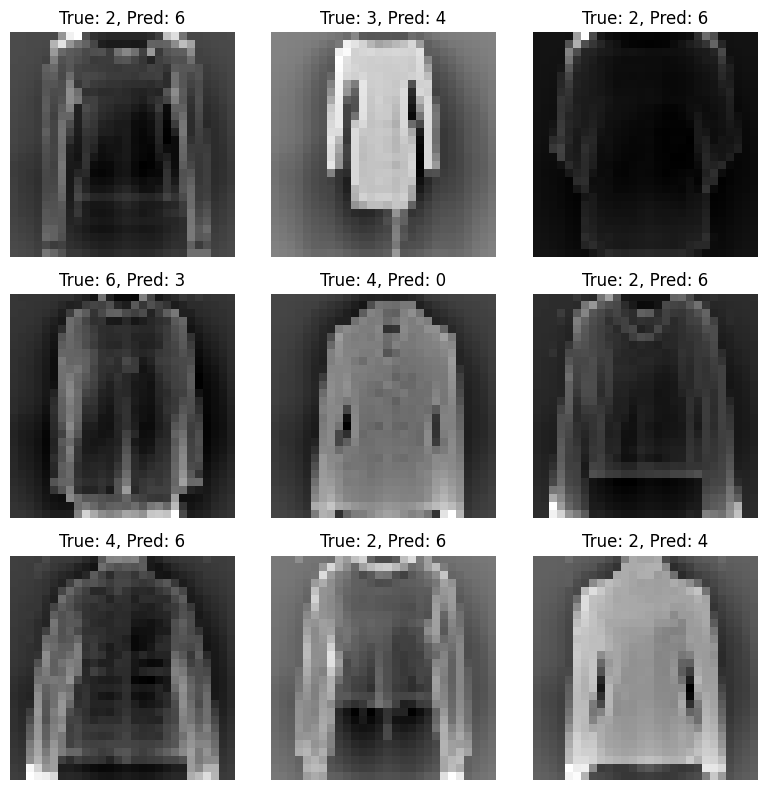

In [8]:
misclassified = np.where(np.argmax(test_predictions, axis=1) != y_test)[0]
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat[:9]):
    ax.imshow(X_test[misclassified[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f'True: {y_test.iloc[misclassified[i]]}, Pred: {np.argmax(test_predictions, axis=1)[misclassified[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Loss vs Iterations

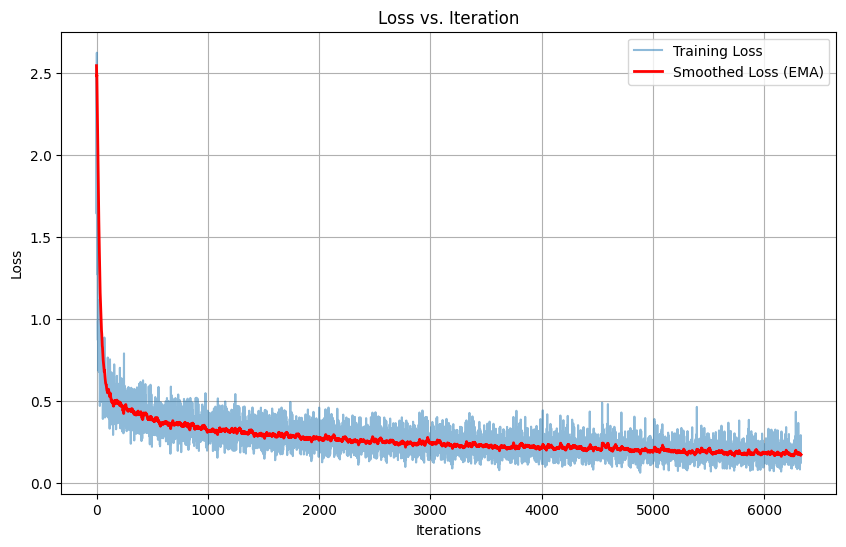

In [9]:
alpha = 0.05

# Compute exponential moving average
ema_loss = np.zeros_like(Neuralnetmodel.loss_history)
ema_loss[0] = Neuralnetmodel.loss_history[0]  # First value is same as the first loss
for i in range(1, len(Neuralnetmodel.loss_history)):
    ema_loss[i] = alpha * Neuralnetmodel.loss_history[i] + (1 - alpha) * ema_loss[i - 1]

# Plotting the training loss and the smoothed EMA loss
plt.figure(figsize=(10, 6))
plt.plot(Neuralnetmodel.loss_history, label='Training Loss', alpha=0.5)
plt.plot(ema_loss, label='Smoothed Loss (EMA)', color='red', linewidth=2)
plt.title('Loss vs. Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## Neural Network Using ADAM optimizer

## Creation of Model

In [20]:
n_features = X_train.shape[1]
n_classes = y_train_onehot.shape[1]
NeuralnetmodelADAM = NeuralNetwork()
NeuralnetmodelADAM.add_layer(n_features, 64, 'relu', optimizer='adam')    # Input layer -> Hidden layer
NeuralnetmodelADAM.add_layer(64, 32, 'relu',optimizer='adam')            # Hidden layer -> Hidden layer
NeuralnetmodelADAM.add_layer(32, n_classes, 'softmax', optimizer='adam')   # Hidden layer -> Output layer
loss_history = NeuralnetmodelADAM.train( X_train, y_train_onehot,batch_size=128,
        learning_rate=0.002, epochs=5)  

Epoch 5/5, Loss: 0.3336, Accuracy: 0.9066, Validation Accuracy 0.8820


## Performance

In [22]:
test_predictionsADAM = NeuralnetmodelADAM.forward(X_test)
test_accuracyADAM = NeuralnetmodelADAM.compute_accuracy(test_predictions, y_test_onehot)
print(f'Test Accuracy: {test_accuracyADAM:.4f}')
metricsADAM = NeuralnetmodelADAM.compute_metrics(test_predictionsADAM, y_test_onehot)
print(f"Macro Precision: {metricsADAM['macro_precision']:.4f} \nMacro Recall: {metricsADAM['macro_precision']:.4f} \nMacro F1 Score: {metricsADAM['macro_f1']:.4f}")

Test Accuracy: 0.8824
Macro Precision: 0.8827 
Macro Recall: 0.8827 
Macro F1 Score: 0.8808


## Loss vs Iterations of ADAM Model

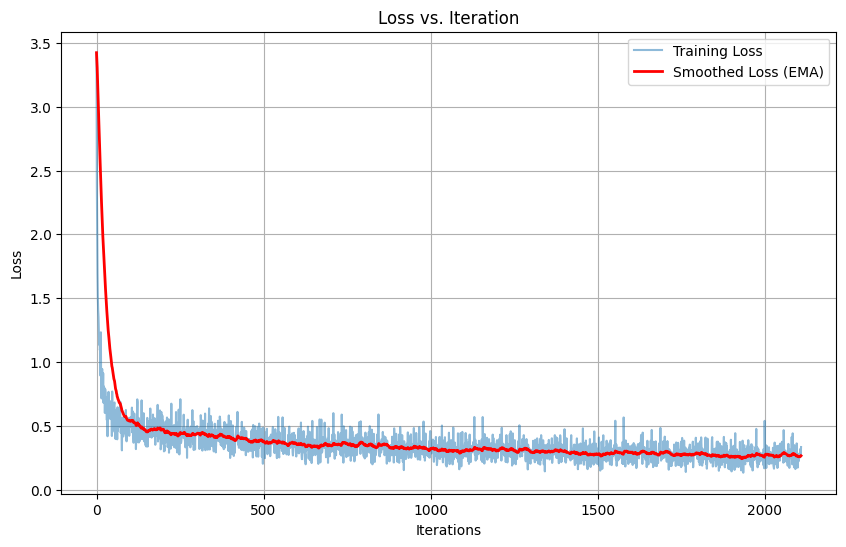

In [23]:
alpha = 0.05

# Compute exponential moving average
ema_loss = np.zeros_like(NeuralnetmodelADAM.loss_history)
ema_loss[0] = NeuralnetmodelADAM.loss_history[0]  # First value is same as the first loss
for i in range(1, len(NeuralnetmodelADAM.loss_history)):
    ema_loss[i] = alpha * NeuralnetmodelADAM.loss_history[i] + (1 - alpha) * ema_loss[i - 1]

# Plotting the training loss and the smoothed EMA loss
plt.figure(figsize=(10, 6))
plt.plot(NeuralnetmodelADAM.loss_history, label='Training Loss', alpha=0.5)
plt.plot(ema_loss, label='Smoothed Loss (EMA)', color='red', linewidth=2)
plt.title('Loss vs. Iteration')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## Weights distribution

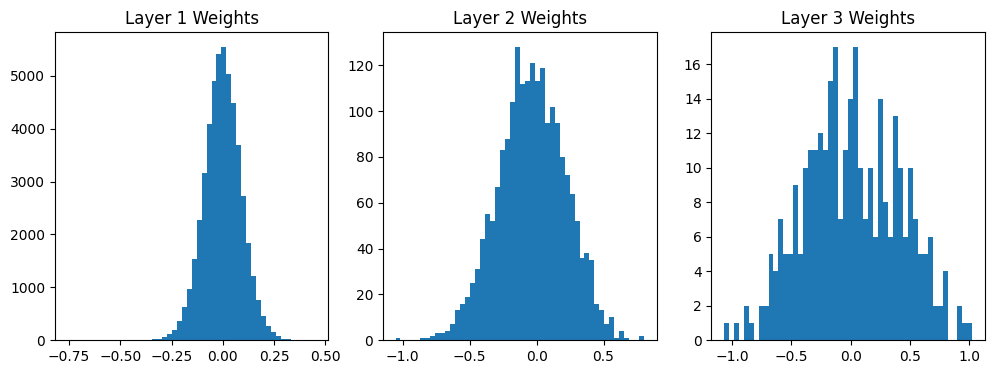

In [24]:
def plot_weight_distributions(model):
    plt.figure(figsize=(12, 4))
    for i, layer in enumerate(model.layers):
        plt.subplot(1, len(model.layers), i+1)
        plt.hist(layer.weights.flatten(), bins=50)
        plt.title(f'Layer {i+1} Weights')
plot_weight_distributions(Neuralnetmodel)

## Test vs True Labels

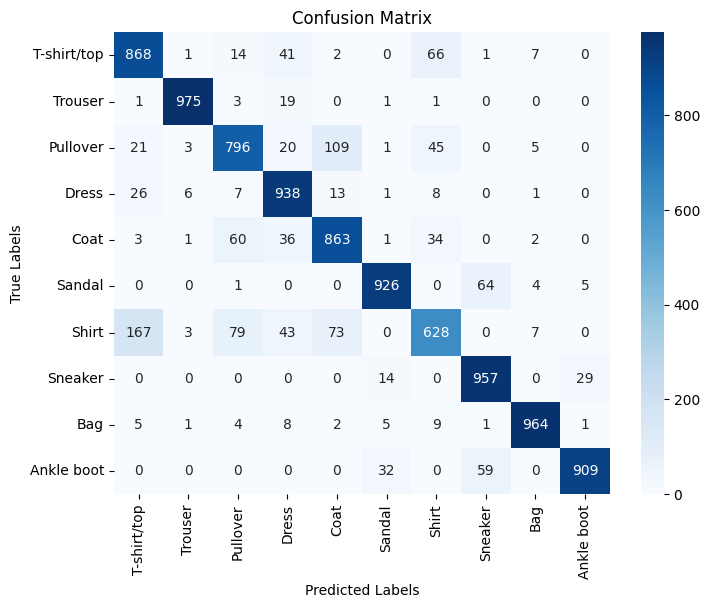

In [ ]:
y_pred_labels = np.argmax(test_predictions, axis=1)  
n_classes = y_test_onehot.shape[1]
confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
for true, pred in zip(y_test_onehot, y_pred_labels):
    confusion_matrix[true, pred] += 1
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Precision, Recall and F1-Score for each Class

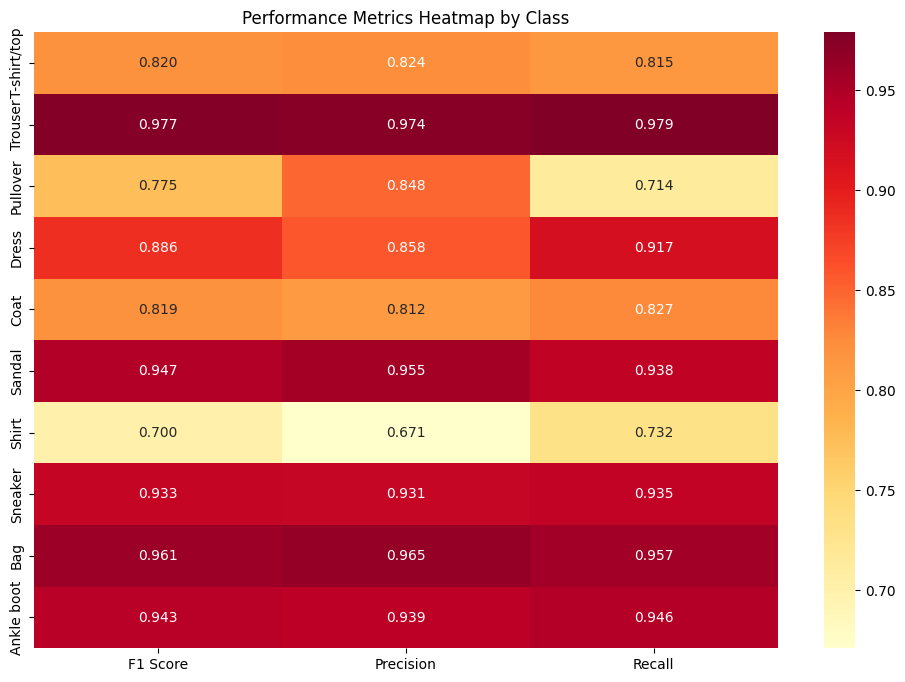

In [ ]:
def plot_metrics_heatmap(metrics, class_labels=None):
    """Plot heatmap of all metrics for each class"""
    per_class_data = []
    for class_name, class_metrics in metrics['per_class_metrics'].items():
        per_class_data.append({
            'Class': class_name,
            'F1 Score': class_metrics['f1_score'],
            'Precision': class_metrics['precision'],
            'Recall': class_metrics['recall']
        })
    data_metrics = pd.DataFrame(per_class_data)
    
    plt.figure(figsize=(12, 8))
    metrics_heatmap_data = data_metrics[['F1 Score', 'Precision', 'Recall']].values
    sns.heatmap(metrics_heatmap_data,
                xticklabels=[ 'F1 Score', 'Precision', 'Recall'],
                yticklabels=class_labels,
                annot=True,
                fmt='.3f',
                cmap='YlOrRd')
    plt.title('Performance Metrics Heatmap by Class')
    plt.show()
plot_metrics_heatmap(metrics, class_labels=class_labels)